In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import pandas as pd

# ESIO Imports
import esio
import esiodata as ed

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
#############################################################
# Load in Data
#############################################################

E = ed.esiodata.load()
data_dir = E.data_dir
grid_dir = E.grid_dir

In [4]:
models = ['ukmo']
runType = 'forecast'
variables = ['sic']

In [5]:
c_model = models[0]
cvar = variables[0]

In [6]:
# Load in Model
model_forecast = os.path.join(E.model[c_model][runType]['sipn_nc'], '*.nc')
ds_model = xr.open_mfdataset(model_forecast)
ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

# Set attributes
ds_model.attrs['model_label'] = E.model[c_model]['model_label']
ds_model.attrs['model_grid_file'] = E.model[c_model]['grid']
ds_model.attrs['stero_grid_file'] = E.obs['NSIDC_0051']['grid']

In [7]:
ds_model

<xarray.Dataset>
Dimensions:    (ensemble: 1, fore_time: 60, init_time: 833, x: 304, y: 448)
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat        (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * fore_time  (fore_time) timedelta64[ns] 1 days 2 days 3 days 4 days ...
  * init_time  (init_time) datetime64[ns] 2015-12-01 2015-12-02 2015-12-03 ...
Dimensions without coordinates: ensemble, x, y
Data variables:
    sic        (ensemble, init_time, fore_time, x, y) float64 dask.array<shape=(1, 833, 60, 304, 448), chunksize=(1, 31, 60, 304, 448)>
Attributes:
    model_label:      ukmo
    model_grid_file:  /home/disk/sipn/nicway/data/grids/MISSING
    stero_grid_file:  /home/disk/sipn/nicway/data/grids/stereo_gridinfo.nc

In [8]:
# Load in Obs
# fig_dir = os.path.join(E.fig_dir, 'obs', 'NSIDC_0081' , 'standard')
%time da_obs_in = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True)
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))
ds_ext = ds_ext.rename({'datetime':'time'})
print('done')

CPU times: user 58.1 s, sys: 3.18 s, total: 1min 1s
Wall time: 1min 1s
done


In [9]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask.nc'))
ds_region.set_coords(['lat','lon'], inplace=True);
ds_region.rename({'nx':'x', 'ny':'y'}, inplace=True);

In [10]:
# Select by variable
da_mod_in = ds_model[cvar]

## Original Land masks from model observed

Text(0.5,1,'Observed')

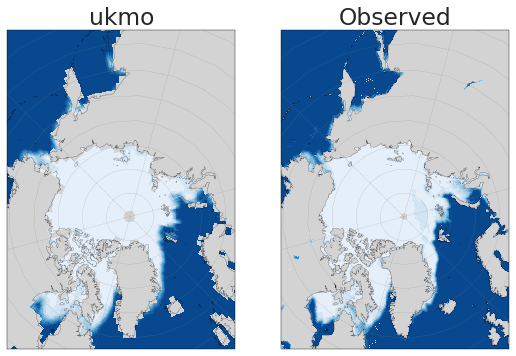

In [11]:
# Plot Original extents
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
c_label = 'Sea Ice Concentration (-)'
c_vmin = 0
c_vmax = 1
(f, axes) = esio.multi_polar_axis(ncols=2, nrows=1, Nplots=3, sizefcter=3)
datemp = da_mod_in.isel(ensemble=0).isel(init_time=10).isel(fore_time=1)
p = datemp.plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
# Calc extents
axes[0].set_title(c_model)

p = da_obs_in.sic.sel(time=(datemp.init_time+datemp.fore_time)).plot.pcolormesh(ax=axes[1], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
axes[1].set_title('Observed')


In [12]:
# Mask out to common extent (both observations and model have non-null values)
(da_obs, da_mod) = esio.mask_common_extent(da_obs_in, da_mod_in)

## Union of Land masks from model observed

Text(0.5,1,'Observed')

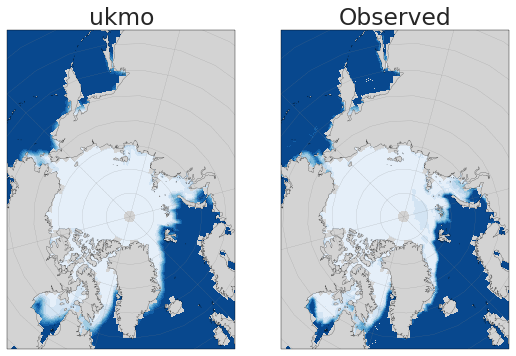

In [13]:
# Plot Common extents
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
c_label = 'Sea Ice Concentration (-)'
c_vmin = 0
c_vmax = 1
(f, axes) = esio.multi_polar_axis(ncols=2, nrows=1, Nplots=3, sizefcter=3)
datemp = da_mod.sic.isel(ensemble=0).isel(init_time=10).isel(fore_time=1)
p = datemp.plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
# Calc extents
axes[0].set_title(c_model)

p = da_obs.sic.sel(time=(datemp.init_time+datemp.fore_time)).plot.pcolormesh(ax=axes[1], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap=cmap_c,
                                      vmin=c_vmin, vmax=c_vmax)
axes[1].set_title('Observed')


In [14]:
# Calculate Sea Ice << EXTENT >>
da_obs_avg = ((da_obs.sic>=0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
da_mod_avg = ((da_mod.sic>=0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)

In [15]:
da_mod_avg #.fore_time.values.astype('timedelta64[D]')

<xarray.DataArray (ensemble: 1, init_time: 833, fore_time: 60)>
dask.array<shape=(1, 833, 60), dtype=float64, chunksize=(1, 31, 60)>
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 1 days 2 days 3 days 4 days ...
  * init_time  (init_time) datetime64[ns] 2015-12-01 2015-12-02 2015-12-03 ...
Dimensions without coordinates: ensemble

In [16]:
# da_mod_avg.chunk({'init_time': 1, 'ensemble': 1, 'fore_time': 215})

In [17]:
# TODO: Need to check for time steps that change with fore_time

In [18]:
# Force model and observations to have the same temporal time step (and slice or average)
# Get model and obs time step
dt_obs = (da_obs_avg.time[1] - da_obs_avg.time[0]).values # Time slices
dt_mod = (da_mod_avg.fore_time[1] - da_mod_avg.fore_time[0]).values
freq_dict = {np.timedelta64(86400000000000,'ns'):'1D', np.timedelta64(1,'M'):'MS'} # TODO: find a way to automate this....

# Aggregate to larger time step
if dt_obs > dt_mod:
    # Aggregate model to obs
    da_mod_avg_agg = da_mod_avg.resample(fore_time=freq_dict[dt_obs], label='left', keep_attrs=True).mean(dim='fore_time') # on fore_time
    da_mod_avg_agg = da_mod_avg_agg.resample(init_time=freq_dict[dt_obs], label='left', keep_attrs=True).mean(dim='init_time') # on init_time
    da_obs_avg_agg = da_obs_avg # pass through
elif dt_obs < dt_mod:
    # Aggregate obs to model
    da_obs_avg_agg = da_obs_avg.resample(time=freq_dict[dt_mod], label='left', keep_attrs=True).mean(dim='time')
    da_mod_avg_agg = da_mod_avg # pass through
else: # They are equal, do nothing
    da_obs_avg_agg = da_obs_avg # pass through
    da_mod_avg_agg = da_mod_avg # pass through

In [19]:
da_obs_avg_agg.time.min().values, da_obs_avg_agg.time.max().values

(numpy.datetime64('2015-01-01T00:00:00.000000000'),
 numpy.datetime64('2018-04-16T00:00:00.000000000'))

In [20]:
da_mod_avg_agg.init_time.min().values, da_mod_avg_agg.init_time.max().values

(numpy.datetime64('2015-12-01T00:00:00.000000000'),
 numpy.datetime64('2018-03-13T00:00:00.000000000'))

In [21]:
# Trim to common time periods
# %autoreload
(ds_obs_trim, ds_mod_trim) = esio.trim_common_times(da_obs_avg_agg, da_mod_avg_agg)

2015-12-01T00:00:00.000000000 2018-04-16T00:00:00.000000000


In [22]:
ds_ext = ds_ext.sel(time=slice(pd.to_datetime(ds_obs_trim.time.values[0]), pd.to_datetime(ds_obs_trim.time.values[-1])))

In [ ]:
# # Temp dump to netcdf then load
# os.chdir( temp_dir )
# c_e, datasets = zip(*ds_mod_trim.to_dataset(name='sic').groupby('ensemble'))
# paths = ['yopp_extent_esns_%s.nc' % e for e in c_e]
# xr.save_mfdataset(datasets, paths)

In [ ]:
# print("Done!")

In [ ]:
# ds_mod_trim = None # Flush memory

In [ ]:
# ds_mod_trim = xr.open_mfdataset(os.path.join(temp_dir, 'GFDL_extent_esns_*.nc'), concat_dim='ensemble')

# ds_mod_trim = ds_mod_trim.reindex(ensemble=sorted(ds_mod_trim.ensemble.values))
# # 
# ds_mod_trim.fore_time.values.astype('timedelta64[D]')

In [ ]:
# Plot pan-Arctic sea ice extent
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
esio.plot_reforecast(ds=ds_mod_trim, axin=ax1, labelin=ds_model.model_label,
                     color='cycle_ensemble', marker=None)
ds_obs_trim.plot(label='NSIDC Near-Real-Time', color='k')
ds_ext.Extent.plot(label='NSIDC Offical Extent', color='m')
ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
plt.legend(loc='lower right',bbox_to_anchor=(1.03, 1.05))
f.autofmt_xdate()
plt.title('')

In [23]:
ds_mod_trim = ds_mod_trim.chunk([1,1,ds_mod_trim.fore_time.size])
ds_mod_trim

<xarray.DataArray (ensemble: 1, init_time: 807, fore_time: 60)>
dask.array<shape=(1, 807, 60), dtype=float64, chunksize=(1, 1, 60)>
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 1 days 2 days 3 days 4 days ...
  * init_time  (init_time) datetime64[ns] 2015-12-01 2015-12-02 2015-12-03 ...
Dimensions without coordinates: ensemble

In [24]:
# Load in memory once
ds_obs_trim.load()

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


<xarray.DataArray (time: 868)>
array([ 9.782362,  9.883899,  9.961479, ..., 12.037795, 12.051102, 11.94447 ])
Coordinates:
  * time       (time) datetime64[ns] 2015-12-01 2015-12-02 2015-12-03 ...
    fore_time  timedelta64[ns] 1 days
    init_time  datetime64[ns] 2015-12-01

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import dask

@dask.delayed
def get_rmse(y_actual, y_predicted):
    return mean_squared_error(y_actual, y_predicted)

In [34]:
# New approach. Loop and build dask graph, then compute all metrics at once
from dask.distributed import Client
client = Client(processes=12) 
mse = []
for (j, it) in enumerate(ds_mod_trim.init_time):
    #print(j)
    c_obs = ds_obs_trim.sel(time = (ds_mod_trim.init_time.sel(init_time=it)  + ds_mod_trim.fore_time).rename({'fore_time':'time'}) )
    for (i, e) in enumerate(ds_mod_trim.ensemble):
        #print(i)
        c_mod = ds_mod_trim.sel(init_time=it).sel(ensemble=e)
        # Compute some metric
        mse.append(get_rmse(c_obs, c_mod))
# Take square root
mse_sum = dask.delayed(sum)(mse)
rmse = dask.delayed(sqrt)(mse_sum)

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7feb63da3378>, <tornado.concurrent.Future object at 0x7febe059bb38>)
Traceback (most recent call last):
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/distributed/comm/core.py", line 185, in connect
    quiet_exceptions=EnvironmentError)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
tornado.gen.TimeoutError: Timeout

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret 

In [35]:
# rmse.visualize(filename='dask.png') 

In [36]:
%time mse_out = rmse.compute()

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7feb7dc9e378>, <tornado.concurrent.Future object at 0x7feb9ef8ff98>)
Traceback (most recent call last):
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/distributed/comm/core.py", line 185, in connect
    quiet_exceptions=EnvironmentError)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
tornado.gen.TimeoutError: Timeout

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret 

KilledWorker: ('open_dataset-137f6ea88dfc33ed4b7fbcb23384abfdsic-e1e2810d3bc7c292d05fb185b8c0c901', 'tcp://127.0.0.1:35845')

In [37]:
mse_out

17.234877638730634

In [ ]:
# Format obs like model
# da_obs_avg_mon_X = esio.format_obs_like_model(ds_mod_trim, ds_obs_trim)

In [ ]:
 # Get observational mean and sigma
# (mu, sigma) = esio.clim_mu_sigma(da_obs_avg_agg, method='MK')

In [ ]:
# c_nrmse = esio.NRMSE(ds_mod_trim, da_obs_avg_mon_X, sigma)
# print(c_nrmse)

In [ ]:
#NRMSE is following the same pattern per months as Hawkins et al. 2016.
# f, ax1 = plt.subplots(1,1)
# f.set_size_inches(10, 6)
# c_nrmse.plot(ax=ax1)